In [3]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

##Ejercicio 1

In [4]:
### a

# obtain the headers
with open('wine.csv', 'r') as file:
    headers = file.readline().split(',')

# read the data from the csv file
data = np.genfromtxt('wine.csv', delimiter=',')

# drop the text headers and keep only the values
data = data[1:]

In [5]:
print(data.shape)
print(data[5])

(178, 14)
[1.42e+01 1.76e+00 2.45e+00 1.52e+01 1.12e+02 3.27e+00 3.39e+00 3.40e-01
 1.97e+00 6.75e+00 1.05e+00 2.85e+00 1.45e+03 1.00e+00]


In [6]:
### b

# get the independant variables
x = data[:, :-1]

# get the single dependant variable
y = data[:, -1]

In [7]:
### c

# obtain the mean vector of data
def get_mean_vector(x):
    return np.mean(x, axis=0)

# obtain the standard deviation vector of data
def get_std_vector(x):
    rows_qty = x.shape[0]
    col_qty = x.shape[1]
    ret = np.zeros(col_qty)

    mean = get_mean_vector(x)

    for i in range(rows_qty):
        ret = ret + (x[i] - mean) ** 2

    return np.sqrt(ret / (rows_qty - 1))

# obtain the normalized vector of data
def get_normailized(x):
    return (x - get_mean_vector(x)) / get_std_vector(x)

x = get_normailized(x)

# estamos centrando los datos restandole el promedio y al dividir por la desviacion estandar lo normalizas

In [8]:
### d

cov = np.cov(x, rowvar=False)

# tiene la propiedad q es simetrica

In [9]:
### e

def get_max_eigenvector(matrix, iter = 20):
    # start with a random vector
    ret = np.random.rand(matrix.shape[1])

# agregar comparacion para stopear antes

    # apply the power method, simply multiplying the matrix with the vector and dividing by the norm
    for _ in range(iter):
        next = np.dot(matrix, ret)
        ret = next / np.linalg.norm(next)
        # calcular eigenvalue y break
    return ret

# obtain the eigenvalue simply by calculating using the formula see in class
def get_related_eigenvalue(matrix, max_eigenvector):
    t_max_eigenvector = np.transpose(max_eigenvector)
    return np.dot(t_max_eigenvector, np.dot(matrix, max_eigenvector))

max_cov_eigenvector = get_max_eigenvector(cov)
max_cov_eigenvalue = get_related_eigenvalue(cov, max_cov_eigenvector)


In [ ]:
### f

def get_max_eigenvectors(matrix, qty = 1, iter = 200):
    
    eigenvectors = np.zeros(shape=(qty, matrix.shape[1]))
    eigenvectors = np.zeros(shape=(qty, matrix.shape[1]))

    for i in range(qty):
        aux = np.random.rand(matrix.shape[1])
        # for the next iteration start with a random vector and remove the components of already calculed eigenvectors
        for _ in range(iter):
            next_aux = np.dot(matrix, aux)
            aux = next_aux / np.linalg.norm(next_aux)

        eigenvectors[i] = aux
        eigenvalues [i] = get_related_eigenvalue(matrix, eigenvectors[i])

    return eigenvectors

def get_max_eigenvalues(matrix, eigenvectors):
    eigenvalues = np.zeros(eigenvectors.shape[0])

    i = 0
    for eigenvector in eigenvectors:
        eigenvalues[i] = get_related_eigenvalue(matrix, eigenvector)
        i = i + 1
        
    return eigenvalues

eigenvectors = get_max_eigenvectors(cov, cov.shape[0])
eigenvalues = np.array(get_max_eigenvalues(cov, eigenvectors))

# print(np.allclose(np.linalg.eig(cov).eigenvalues, eigenvalues, rtol=1e-03))
# print(np.allclose(np.transpose(np.linalg.eig(cov).eigenvectors  ** 2), eigenvectors  ** 2, rtol=1e-03))

In [10]:
### f

def get_max_eigenvectors(matrix, qty = 1, iter = 200):
    
    eigenvectors = np.zeros(shape=(qty, matrix.shape[1]))

    for i in range(qty):
        aux = np.random.rand(matrix.shape[1])

        # for the next iteration start with a random vector and remove the components of already calculed eigenvectors
        for _ in range(iter):
            for eigenvector in eigenvectors:
                aux = aux - np.dot(eigenvector, aux) * eigenvector
            next_aux = np.dot(matrix, aux)
            aux = next_aux / np.linalg.norm(next_aux)

        eigenvectors[i] = aux

    return eigenvectors

def get_max_eigenvalues(matrix, eigenvectors):
    eigenvalues = np.zeros(eigenvectors.shape[0])

    i = 0
    for eigenvector in eigenvectors:
        eigenvalues[i] = get_related_eigenvalue(matrix, eigenvector)
        i = i + 1
        
    return eigenvalues

eigenvectors = get_max_eigenvectors(cov, cov.shape[0])
eigenvalues = np.array(get_max_eigenvalues(cov, eigenvectors))

# print(np.allclose(np.linalg.eig(cov).eigenvalues, eigenvalues, rtol=1e-03))
# print(np.allclose(np.transpose(np.linalg.eig(cov).eigenvectors  ** 2), eigenvectors  ** 2, rtol=1e-03))

## la matriz cov tiene dimension de caracteristicas x caracteiscticas y como es simetrica tiene la misma cantidad de eigenvalues reales
# 
#  los primeros autovectores representan la direcciones mas significativas que contienne mayor varianza

In [11]:
### g

# predict the result label of the input array containing the samples atributes and needs the eigenvectors of the covariance matrix
def predict_data(input, eigenvectors):

    # transform the data into the new basis using the eigenvectors
    transformed_x = np.dot(x, np.transpose(eigenvectors))
    
    knn = KNeighborsClassifier(n_neighbors=5)

    # fit the transformed data in to the KNN model
    knn.fit(transformed_x, y)

    # predit the result transforming the input data into the new basis and then using the knn model
    return knn.predict(np.dot(input, np.transpose(eigenvectors)))

# take all the samples of the data which their index is divisible by 10 for testing the model
test = x[::10]
correct_labels = y[::10]
predicted_data = predict_data(test, eigenvectors)

for i in range(len(predicted_data)):
    print (", actual is: " + str(correct_labels[i]) + "prediction is: " + str(predicted_data[i]))


, actual is: 1.0prediction is: 1.0
, actual is: 1.0prediction is: 1.0
, actual is: 1.0prediction is: 1.0
, actual is: 1.0prediction is: 1.0
, actual is: 1.0prediction is: 1.0
, actual is: 1.0prediction is: 1.0
, actual is: 2.0prediction is: 2.0
, actual is: 2.0prediction is: 2.0
, actual is: 2.0prediction is: 2.0
, actual is: 2.0prediction is: 2.0
, actual is: 2.0prediction is: 2.0
, actual is: 2.0prediction is: 2.0
, actual is: 2.0prediction is: 1.0
, actual is: 3.0prediction is: 3.0
, actual is: 3.0prediction is: 3.0
, actual is: 3.0prediction is: 3.0
, actual is: 3.0prediction is: 3.0
, actual is: 3.0prediction is: 3.0


##Ejercicio 2

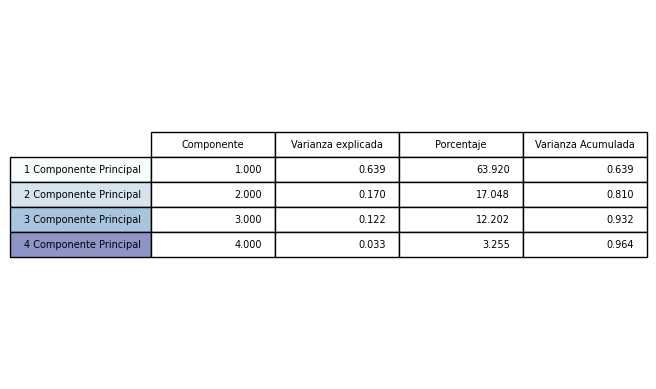

In [12]:
### a

iter = 4
components = []
explain_varianze = []
percent_explain_varianze = []
accumulated_explain_varianze = []

for i in range(iter):
    components.append(i + 1)
    explain_varianze.append(eigenvalues[i] / np.sum(eigenvalues))
    percent_explain_varianze.append(100 * eigenvalues[i] / np.sum(eigenvalues))
    accumulated_explain_varianze.append(np.sum(eigenvalues[0:i + 1]) / np.sum(eigenvalues))

data =  np.transpose(np.array([
            components,
            explain_varianze,
            percent_explain_varianze,
            accumulated_explain_varianze,
        ]))

cell_text = []
for row in data:
    cell_text.append([f'{x:1.3f}' for x in row])

columns = ('Componente', 'Varianza explicada', 'Porcentaje', 'Varianza Acumulada')
rows = ['%d Componente Principal' % x for x in (1,2,3,4)]
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='center')

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
the_table.scale(1, 1.5)

plt.show()

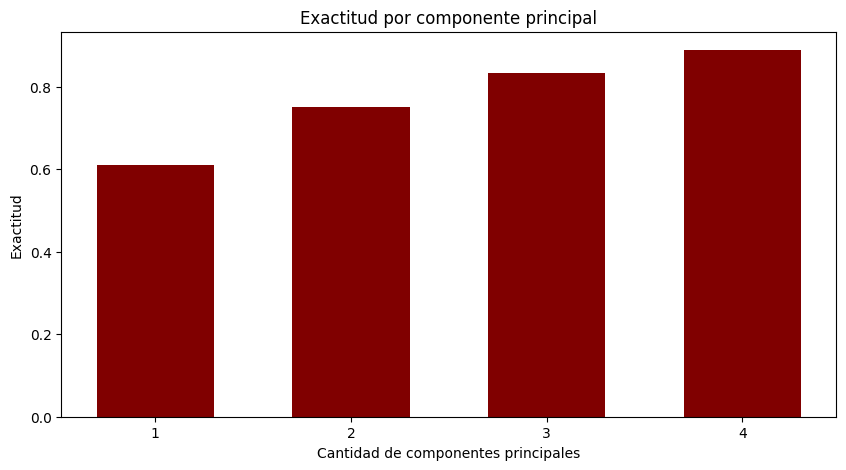

In [13]:
### b

from sklearn.metrics import confusion_matrix

# predict the result label of the input array containing the samples atributes and needs the eigenvectors of the covariance matrix
def benchmark(x, y, eigenvectors):

    # make a shuffled training and test set
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)
    
    #transform the training data into the new basis using the eigenvectors
    transformed_x_train = np.dot(x_train, np.transpose(eigenvectors))

    # for the case when only use the first principal component 
    # if the training data is a vector, transform it into a matrix with one column
    if (transformed_x_train.shape == (transformed_x_train.shape[0],)):
        transformed_x_train = transformed_x_train.reshape(-1, 1)

    knn = KNeighborsClassifier(n_neighbors=5)

    # fit the transformed data in to the KNN model
    knn.fit(transformed_x_train, y_train)

    #transform the training data into the new basis using the eigenvectors
    transformed_x_test = np.dot(x_test, np.transpose(eigenvectors))

    # for the case when only use the first principal component 
    # if the training data is a vector, transform it into a matrix with one column
    if (transformed_x_test.shape == (transformed_x_test.shape[0],)):
        transformed_x_test = transformed_x_test.reshape(-1, 1)

    # predit the result transforming the test data into the new basis and then using the knn model
    y_pred = knn.predict(transformed_x_test)

    # calculate the accuracy
    accuracy = np.sum(y_pred == y_test) / len(y_test)

    return accuracy, confusion_matrix(y_test, y_pred, labels=knn.classes_)

iter = 4
x_labels = []
y_lables = []
confusion_matrixes = []

for i in range(iter):
    accurracy, conf_matrix = benchmark(x, y, eigenvectors[np.arange(0, i + 1), :])
    x_labels.append(f'{i + 1}')
    y_lables.append(accurracy)
    confusion_matrixes.append(conf_matrix)
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x_labels, y_lables, color ='maroon', width = 0.6)
 
plt.xlabel("Cantidad de componentes principales")
plt.ylabel("Exactitud")
plt.title("Exactitud por componente principal")
plt.show()


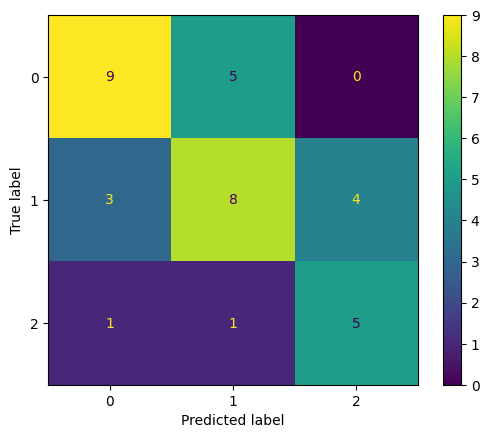

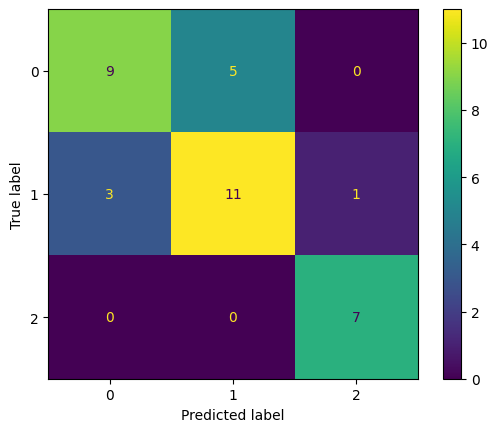

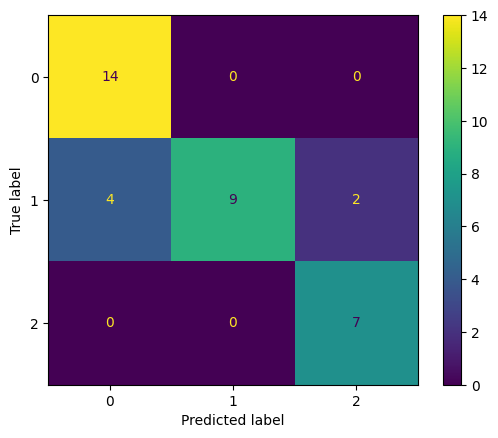

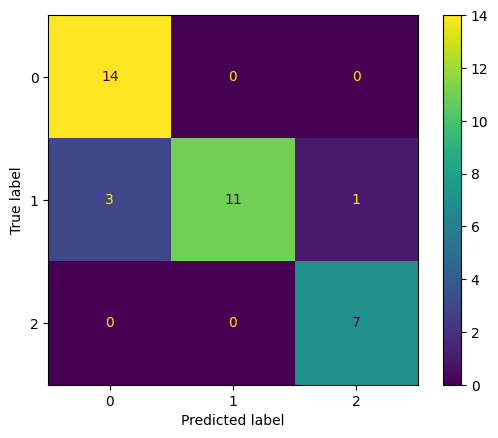

In [14]:
### c

from sklearn.metrics import ConfusionMatrixDisplay

for i in range(iter):
    disp = ConfusionMatrixDisplay(confusion_matrixes[i])
    disp.plot()
    plt.show()